## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio,l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_ratio,l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model



"""
建立神經網路，並加入 dropout layer
"""
def build_mlp_dropout(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


"""
建立神經網路，並加入 BN layer
"""
def build_mlp_BN(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:

"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
keras.backend.clear_session() 
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]
exp_name_tag = "no"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 174u

Epoch 49/50
50000/50000 [==============================] - 9s 190us/step - loss: 0.8785 - accuracy: 0.6923 - val_loss: 1.4094 - val_accuracy: 0.5269
Epoch 50/50
50000/50000 [==============================] - 9s 176us/step - loss: 0.8677 - accuracy: 0.6960 - val_loss: 1.4319 - val_accuracy: 0.5226


In [8]:
keras.backend.clear_session() 
model = build_mlp_l1_l2(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]
exp_name_tag = "build_mlp_l1_l2"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 277

50000/50000 [==============================] - 12s 243us/step - loss: 2.6978 - accuracy: 0.6150 - val_loss: 2.9741 - val_accuracy: 0.5133
Epoch 49/50
50000/50000 [==============================] - 12s 247us/step - loss: 2.6520 - accuracy: 0.6199 - val_loss: 3.3845 - val_accuracy: 0.4245
Epoch 50/50
50000/50000 [==============================] - 14s 285us/step - loss: 2.6303 - accuracy: 0.6190 - val_loss: 2.9230 - val_accuracy: 0.5132


In [9]:
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp_dropout(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]
exp_name_tag = "build_mlp_dropout"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0   

Epoch 46/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.2524 - accuracy: 0.5540 - val_loss: 1.3065 - val_accuracy: 0.5352
Epoch 47/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.2487 - accuracy: 0.5530 - val_loss: 1.3085 - val_accuracy: 0.5316
Epoch 48/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.2434 - accuracy: 0.5549 - val_loss: 1.2969 - val_accuracy: 0.5355
Epoch 49/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.2350 - accuracy: 0.5588 - val_loss: 1.3079 - val_accuracy: 0.5318
Epoch 50/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.2308 - accuracy: 0.5588 - val_loss: 1.2979 - val_accuracy: 0.5320


In [10]:
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp_BN(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]
exp_name_tag = "build_mlp_BN"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

Epoch 46/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.2073 - accuracy: 0.9417 - val_loss: 2.3100 - val_accuracy: 0.4891
Epoch 47/50
50000/50000 [==============================] - 10s 210us/step - loss: 0.2052 - accuracy: 0.9418 - val_loss: 2.4419 - val_accuracy: 0.4566
Epoch 48/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.1941 - accuracy: 0.9458 - val_loss: 2.3978 - val_accuracy: 0.4759
Epoch 49/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.1845 - accuracy: 0.9485 - val_loss: 2.4874 - val_accuracy: 0.4604
Epoch 50/50
50000/50000 [==============================] - 10s 203us/step - loss: 0.1816 - accuracy: 0.9481 - val_loss: 2.5225 - val_accuracy: 0.4641


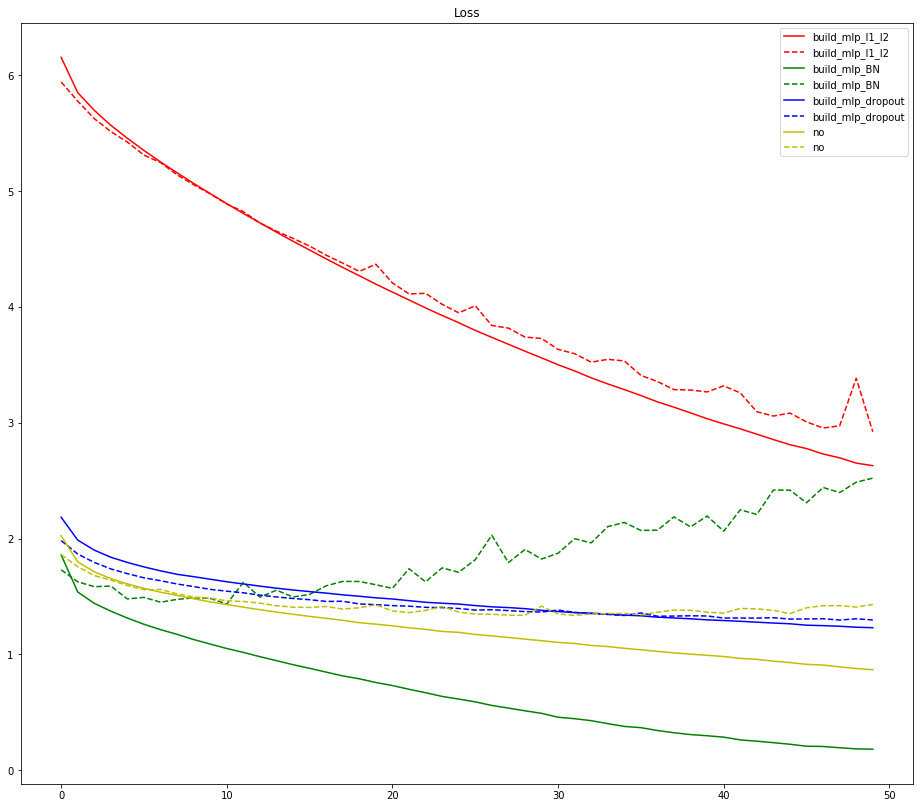

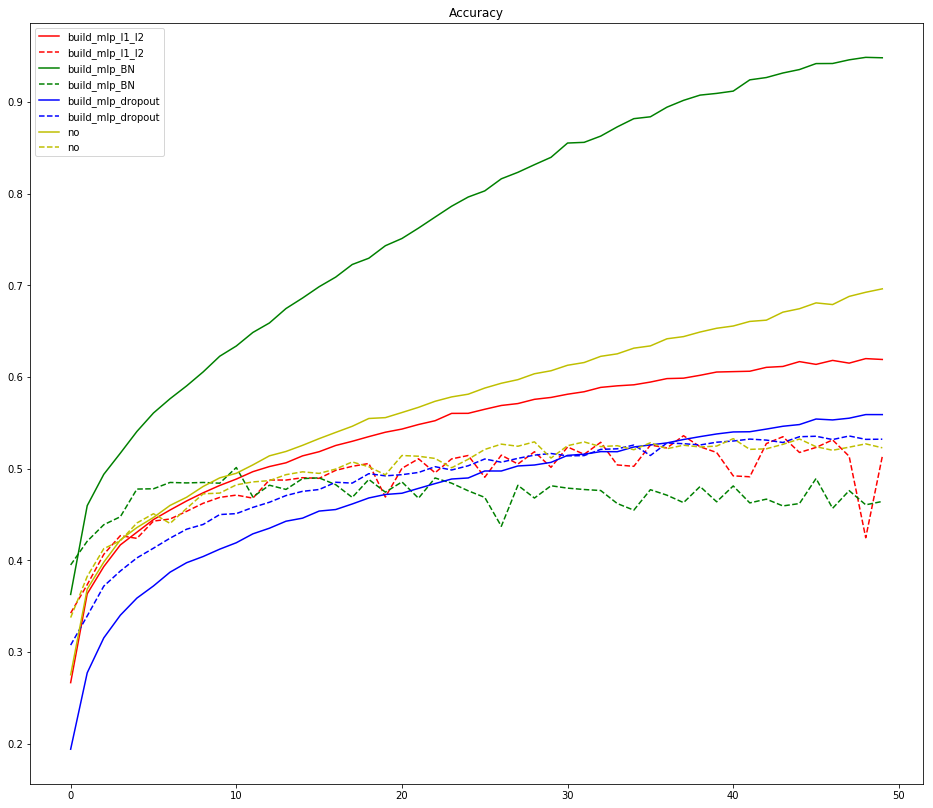

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

plt.figure(figsize=(16,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()